# Diffusion Model test

In [142]:
import torch_geometric
import dgl
import random
import torch
from torch.utils.data import DataLoader
import selection
import argparse
import schedules
import numpy as np

In [143]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--subgraph_size', type=int, default=16)
parser.add_argument('--num_save', type=int, default=50)
parser.add_argument('--file', type=str, default="./out.csv")
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--timesteps', type=int, default=400)
parser.add_argument('--epochs', type=int, default=5)
parser.add_argument('--method', type=str, default='walk', choices=[
    'walk', 'rand', 'cluster'
])
parser.add_argument('--dataset', type=str, default='cora', choices=[
    'cora', 'chameleon', 'BlogCatalog', 'flickr'
])

args = parser.parse_args("")


device = "cuda:0" if torch.cuda.is_available() else "cpu"

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if device != 'cpu': torch.cuda.manual_seed(args.seed)

In [144]:
if args.dataset == 'cora': 
    dataset = dgl.data.CoraGraphDataset()
    g = dataset[0]
if args.dataset == 'chameleon':
    import loadSNAP
    import utils
    graph = dgl.from_networkx(loadSNAP.load_graph("chameleon/musae_chameleon_edges.csv"))

    # Load labels
    labels = torch.tensor(loadSNAP.load_labels("chameleon/musae_chameleon_target.csv"))
    labels = utils.discretize(labels, 5)

    graph.ndata['label'] = labels
    labels = labels.to(device)

    # Load feats
    rawFeat = loadSNAP.load_features("chameleon/musae_chameleon_features.json")
    feat = torch.zeros((graph.num_nodes(), 4000))
    for key in rawFeat:
        feat[key] = utils.idx_to_bool(torch.tensor(rawFeat[key]), 4000)
    graph.ndata['feat'] = feat
    feat = feat.to(device)

    # Train test split
    train_mask = torch.bernoulli(torch.full([graph.num_nodes()], 0.3)).bool()
    graph.ndata['train_mask'] = train_mask
    graph.ndata['test_mask'] = ~train_mask
    adj = graph.adj().to_dense()
    g = graph
else:
    import dataloader
    graph = dataloader.load_DGL(args.dataset)
    feat = graph.ndata['feat'].to(device)
    labels = graph.ndata['label'].to(device)
    adj = graph.adj().to_dense()
    g = graph

subgraph_size = args.subgraph_size
batch_size = args.batch_size
timesteps = args.timesteps

if args.method == 'walk': method = selection.subgraph_node2vec_random_walk
if args.method == 'rand': method = selection.subgraph_random
if args.method == 'cluster': method = selection.subgraph_cluster

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [145]:
dataset = []
channels = 1
for i in range(batch_size * 50):
    dataset.append({"pixel_values" : (method(subgraph_size, g).adj().to_dense().unsqueeze(0) * 2) - 1})

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [146]:
from torch.optim import Adam
from unet import Unet
import torch

model = Unet(
    dim=subgraph_size,
    channels=channels,
    dim_mults=(1, 2, 4, 8)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [147]:
import importlib
import unet
importlib.reload(unet)

unet.trainUnet(
    model=model,
    epochs=args.epochs,
    dataloader=dataloader,
    optimizer=Adam(model.parameters(), lr=1e-3),
    device=device,
    timesteps=timesteps,
    scheduler=schedules.linear_beta_schedule
)

Epoch: 0


Batch: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s, loss=0.256]


Epoch: 1


Batch: 100%|██████████| 50/50 [00:05<00:00,  9.45it/s, loss=0.133]


Epoch: 2


Batch: 100%|██████████| 50/50 [00:05<00:00,  8.66it/s, loss=0.1]   


Epoch: 3


Batch: 100%|██████████| 50/50 [00:06<00:00,  8.20it/s, loss=0.0737]


Epoch: 4


Batch: 100%|██████████| 50/50 [00:06<00:00,  7.77it/s, loss=0.0704]


In [148]:
import sampling
samples = sampling.sample(
    model, 
    image_size=subgraph_size, 
    batch_size=batch_size, 
    channels=channels, 
    scheduler=schedules.linear_beta_schedule, 
    timesteps=timesteps
)

sampling loop time step: 100%|██████████| 400/400 [00:06<00:00, 65.72it/s]


<Figure size 432x288 with 0 Axes>

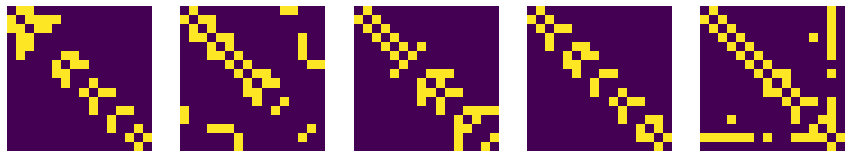

<Figure size 432x288 with 0 Axes>

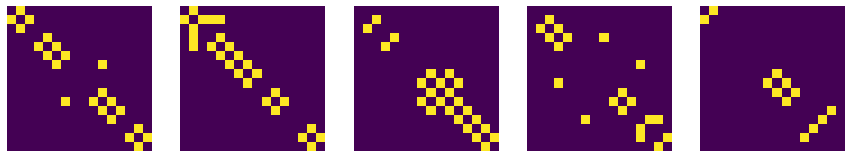

In [149]:
import matplotlib.pyplot as plt

def showPics(num, imgs):
    plt.figure()
    f, axarr = plt.subplots(1, num, figsize=(15,15))
    rand = random.sample(range(len(imgs)), num)
    for i, imgIdx in enumerate(rand):
        # print(i['pixel_values'][0].squeeze().shape)
        axarr[i].imshow(imgs[imgIdx])
        axarr[i].axis('off')
        if i == num - 1: break



def mirror(A: np.ndarray):
    return np.tril(A) + np.triu(A.T, 1)

train_data = [x["pixel_values"].squeeze() for x in dataset]
pred_data = [mirror(x) for x in (samples[-1].squeeze() > 0)]

comparisons = 5
showPics(comparisons, train_data)
showPics(comparisons, pred_data)

In [150]:
import networkx as nx

def calculateStats(adj: torch.tensor, label: str, index: int):
    out = {}
    adj = mirror(adj > 0)
    nxg = nx.from_numpy_matrix(adj)

    out['label'] = label
    out['index'] = index
    out['num_edges'] = adj.sum()
    out['num_nodes'] = adj.shape[0]
    out['density'] = adj.sum() / adj.shape[0]
    out['num_triangles'] = int(sum(nx.triangles(nxg).values()) / 3)
    out['max_diameter'] = max([max(j.values()) for (i,j) in nx.shortest_path_length(nxg)])

    out.update(vars(args))
    out.pop("file")
    return out


In [151]:
def avg(stats):
    avg = {
        'density': 0,
        'max_diameter': 0
    }
    ct = 0
    for stat in stats:
        ct += 1
        avg['density'] += stat.get('density') or 0
        avg['max_diameter'] += stat.get('max_diameter') or 0
    
    for key in avg:
        avg[key] /= ct
    
    return avg

print(avg([calculateStats(train_data[x].numpy(), "train", i) for x in range(len(train_data))]))
print(avg([calculateStats(pred_data[x], "test", i) for x in range(len(pred_data))]))

{'density': 2.545869140625, 'max_diameter': 7.36265625}
{'density': 1.264892578125, 'max_diameter': 4.5703125}


In [152]:
# calculateStats(pred_data[2], "pred", i)

In [153]:
calculateStats(train_data[2].numpy(), "train", i)

{'label': 'train',
 'index': 12799,
 'num_edges': 44,
 'num_nodes': 16,
 'density': 2.75,
 'num_triangles': 6,
 'max_diameter': 6,
 'seed': 123,
 'subgraph_size': 16,
 'num_save': 50,
 'batch_size': 256,
 'timesteps': 400,
 'epochs': 5,
 'method': 'walk',
 'dataset': 'cora'}

In [154]:
trainStats = [calculateStats(train_data[x].numpy(), "train", i) for x in range(len(train_data))]

In [155]:
trainStats[-1]

{'label': 'train',
 'index': 12799,
 'num_edges': 32,
 'num_nodes': 16,
 'density': 2.0,
 'num_triangles': 0,
 'max_diameter': 10,
 'seed': 123,
 'subgraph_size': 16,
 'num_save': 50,
 'batch_size': 256,
 'timesteps': 400,
 'epochs': 5,
 'method': 'walk',
 'dataset': 'cora'}

In [156]:
def avg(data):
    stats = [calculateStats(train_data[x].numpy(), "train", i) for x in range(len(train_data))]
    avg = {
        'density': 0,
        'max_diameter': 0
    }
    ct = 0
    for stat in stats:
        ct += 1
        avg['density'] += stat.get('density') or 0
        avg['max_diameter'] += stat.get('max_diameter') or 0
    
    for key in avg:
        avg[key] /= ct
    
    return avg

avg(train_data)

{'density': 2.545869140625, 'max_diameter': 7.36265625}

In [157]:
import export

for i, idx in enumerate(random.sample(range(len(train_data)), args.num_save)):
    export.saveData(args.file, calculateStats(train_data[idx].numpy(), "train", i))

for i, idx in enumerate(random.sample(range(len(pred_data)), args.num_save)):
    export.saveData(args.file, calculateStats(pred_data[idx], "pred", i))